In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.svm import SVC
from pathlib import Path
import numpy as np
import seaborn as sns
base_folder = 'results/schaefer400'
atlas_basename = 'schaefer400'
output = Path('results')
atlas_networks = [dir_ for dir_ in output.iterdir() if
                        dir_.is_dir() and atlas_basename in dir_.name]
output = output / atlas_basename
subjects_df = pd.read_csv('clinical_data.csv')
subjects_df = subjects_df.astype({'id': int})
subjects_df = subjects_df.set_index('id')
filename = Path('global_measures.csv')

networks_names = {
      "SalVentAttnLH": "Salience/Ventral Attention (Left Hemisphere)", "SalVentAttn": "Salience/Ventral Attention",
      "DorsAttn": "Dorsal Attention", "Cont": "Frontoparietal", "Default": "Default", "Vis": "Visual",
      "Limbic": "Limbic", "Global": "Global"
    }
networks_nce = {
      "SalVentAttnLH": "language", "SalVentAttn": "executive", "DorsAttn": "attention",
      "Cont": "visuoespatial", "Default": "memory", "Vis": "visuoespatial", "Limbic": "memory", "Global": "attention"
    }

In [2]:
def add_curve(graph_densities, measure, lower_error, upper_error, group, color_index, ax):
    ax.plot(graph_densities, measure, label=group, color=f'C{color_index}')
    ax.plot(graph_densities, lower_error, alpha=0.1, color=f'C{color_index}')
    ax.plot(graph_densities, upper_error, alpha=0.1, color=f'C{color_index}')
    ax.legend()
    ax.fill_between(graph_densities, lower_error, upper_error, alpha=0.2)

    
def add_statistical_significance(p_at_thresholds, ax, significance_levels, eps=1e-4):
    pvalues = p_at_thresholds[p_at_thresholds.columns[0]]
    labels = ['*' * i for i in range(len(significance_levels), 0, -1)]
    significance_levels.insert(0, 0.0)
    significance_levels.append(1.)
    labels.append('ns')
    categorized_pvalues = pd.cut(pvalues, significance_levels, right=False, labels=labels)
    spacing = 0.1
    if len(pvalues) > 1:
        spacing = pvalues.index[1] - pvalues.index[0] + eps

    significance_bar(ax, categorized_pvalues, labels, spacing)
    
    
def significance_bar(ax, categorized_pvalues, labels, spacing):
    for label in labels:
        significant_values = categorized_pvalues[categorized_pvalues == label]
        # Build a list of tuples with the start and end of each significant region
        if len(significant_values) > 0 and label not in 'ns':
            significant_regions = [(significant_values.index[0], significant_values.index[0])]
            for i, threshold in enumerate(significant_values.index):
                if i > 0:
                    if threshold - significant_values.index[i - 1] > spacing:
                        significant_regions.append((threshold, threshold))
                    else:
                        significant_regions[-1] = (significant_regions[-1][0], threshold)
            for region in significant_regions:
                ax.plot(region, [ax.get_ylim()[1] * 0.98, ax.get_ylim()[1] * 0.98], marker=f'{label}', linewidth=1,
                        color='k', alpha=0.8)

def get_network_name(atlas_basename, network):
    return network.lstrip(f'{atlas_basename}_') if is_network(network) else 'Global'


def is_network(atlas_name):
    return len(atlas_name.split('_')) > 1
                

In [17]:
def meshgrid(x, y, h=.02, offset=0.07):
    x_min, x_max = x.min() - offset, x.max() + offset
    y_min, y_max = y.min() - offset, y.max() + offset
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def add_svm_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)


def fit_and_plot_svm(ax, nces, values, categories):
    df = pd.DataFrame({'nce': nces, 'measure': values, 'group': categories}).dropna()
    clf_nces, clf = SVC(), SVC()
    features = df[['nce', 'measure']].values.astype(float)
    categories = df['group'].values.astype(int)
    nces = features[:, 0].reshape(-1, 1)
    clf_nces.fit(nces, categories)
    clf.fit(features, categories)
    nces_accuracy = clf_nces.score(nces, categories)
    measures_accuracy = clf.score(features, categories)
    xx, yy = meshgrid(features[:, 0], features[:, 1])
    add_svm_contours(ax, clf, xx, yy, cmap='coolwarm', alpha=0.1)
    
    return measures_accuracy - nces_accuracy


In [13]:
def plot_measure_to_nce(atlas_basename, networks_dirs, networks_names, subjects_df, measure_label, measure_desc,
                        networks_nce, output, filename):
    ncols, nrows = 2, -(-len(networks_dirs) // 2)
    fig, axes = plt.subplots(figsize=(15, 5 * nrows), nrows=nrows, ncols=ncols)
    gains = {network.name: {} for network in networks_dirs}
    for i, network in enumerate(networks_dirs):
        ax = axes[i // 2, i % 2] if nrows > 1 else axes[i % 2]
        network_basename = get_network_name(atlas_basename, network.name)
        if network_basename not in networks_nce:
            continue
        network_nce = networks_nce[network_basename]
        groups = sorted(subjects_df['group'].unique())
        graph_density, nces, values, categories = 0.0, [], [], []
        for j, group in enumerate(groups):
            group_df = subjects_df[subjects_df['group'] == group]
            group_network_measures = pd.read_pickle(network / f'{filename.stem}_{group}.pkl')
            measures_at_threshold = group_network_measures.sort_values(by='threshold').iloc[-1]
            if measure_label not in measures_at_threshold.index:
                continue
            graph_density = measures_at_threshold['threshold']
            nces.extend(group_df[network_nce].values)
            values.extend(measures_at_threshold[measure_label])
            categories.extend([j] * len(group_df))
            ax.scatter(group_df[network_nce].values, measures_at_threshold[measure_label], label=group)
        gains[network.name] = fit_and_plot_svm(ax, nces, values, categories)
        ax.legend()
        ax.set_title(f'{networks_names[network_basename]}')
        ax.set_ylabel(f'{measure_desc} at t={graph_density:.2f}')
        ax.set_xlabel(f'{network_nce} score')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.suptitle(measure_desc)
    fig.savefig(output / f'{measure_label}_to_NCE.png')
    plt.show()

    return gains

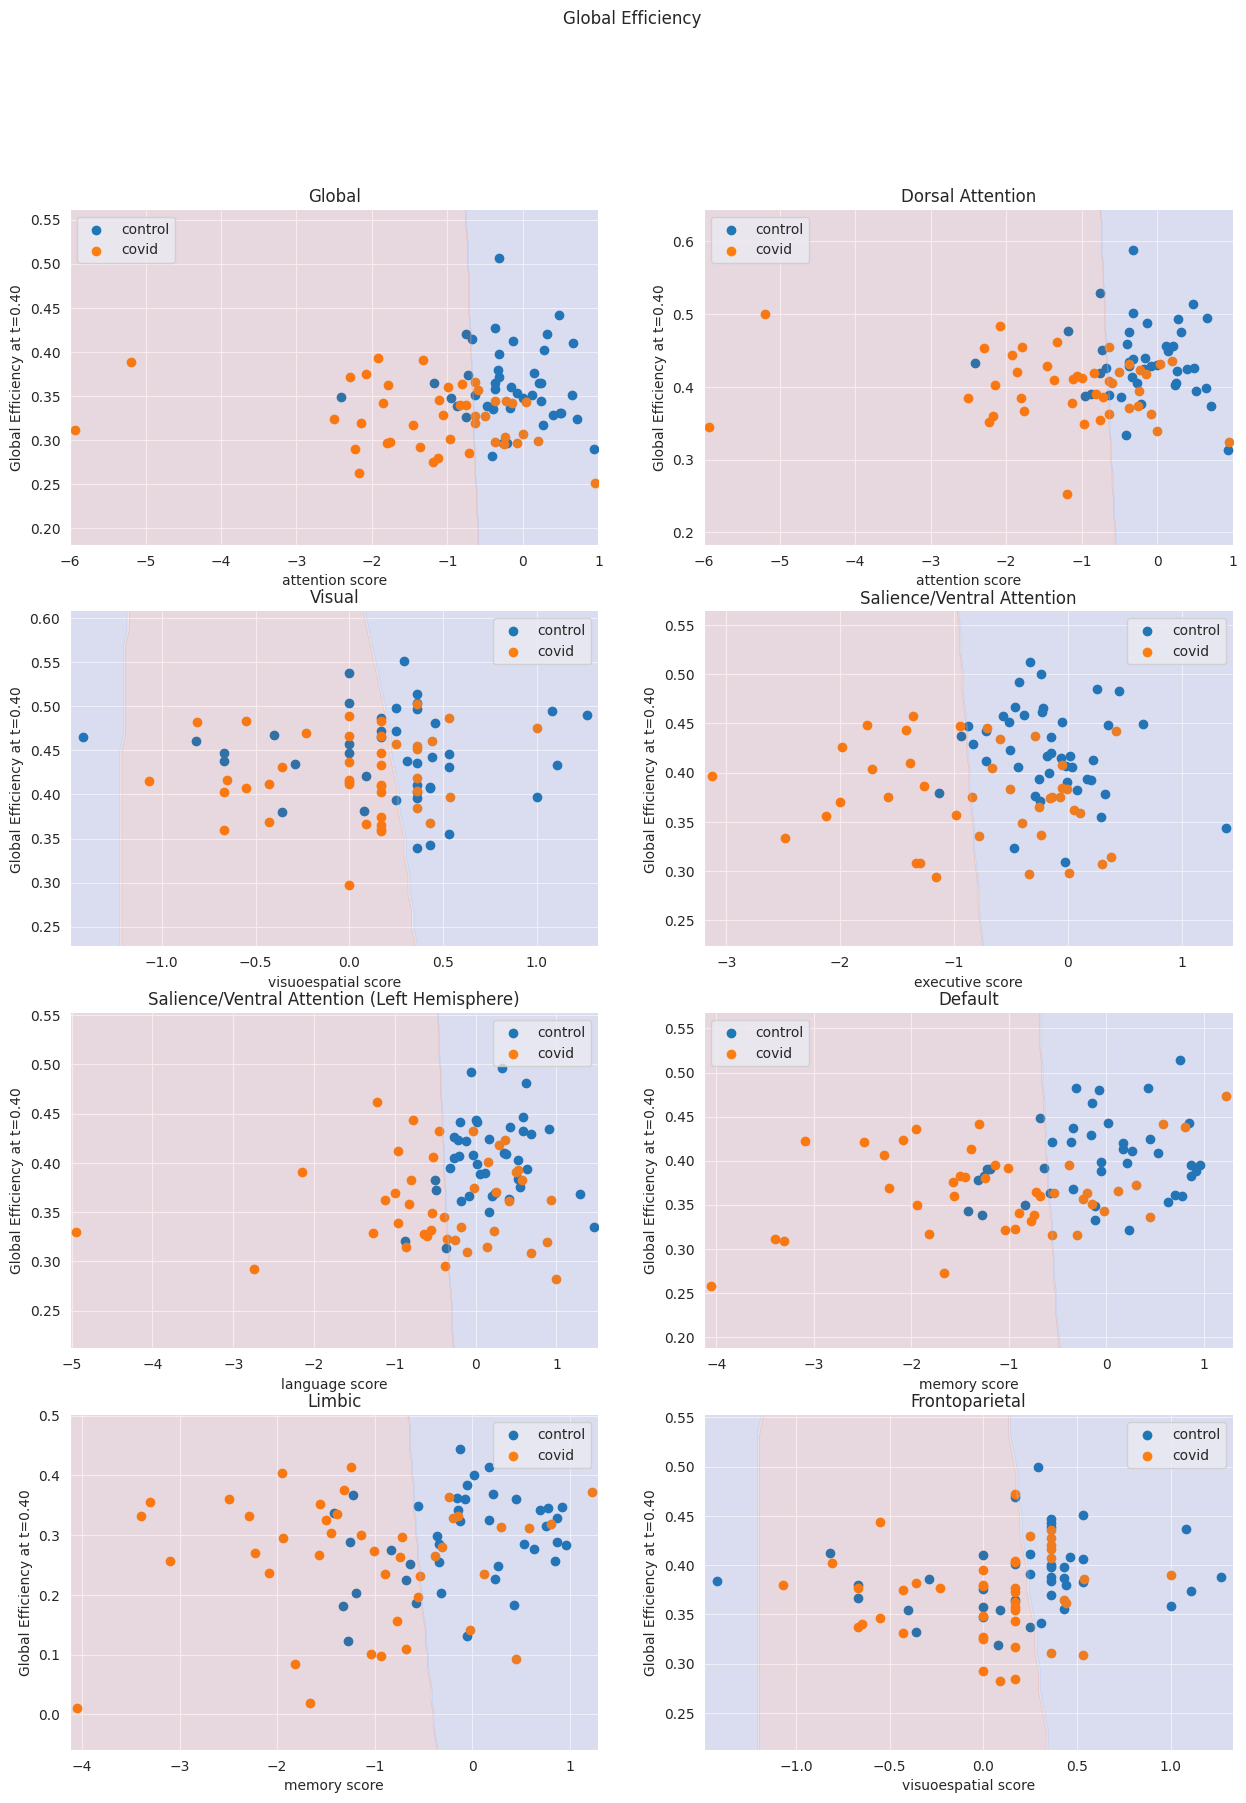

{'schaefer400': 0.011904761904761862,
 'schaefer400_DorsAttn': 0.0,
 'schaefer400_Vis': -0.012048192771084265,
 'schaefer400_SalVentAttn': 0.0,
 'schaefer400_SalVentAttnLH': 0.024691358024691357,
 'schaefer400_Default': 0.012195121951219523,
 'schaefer400_Limbic': 0.024390243902439046,
 'schaefer400_Cont': -0.012048192771084265}

In [18]:
plot_measure_to_nce(atlas_basename, atlas_networks, networks_names, subjects_df, 'global_efficiency', 'Global Efficiency', networks_nce, output, filename)

In [70]:
def plot_measure(atlas_basename, networks_dirs, networks_names, measure_label, measure_desc, output, filename):
    ncols, nrows = 2, -(-len(networks_dirs) // 2)
    fig, axes = plt.subplots(figsize=(15, 5 * nrows), nrows=nrows, ncols=ncols)
    aucs = {network.name: {} for network in networks_dirs}
    for i, network in enumerate(networks_dirs):
        measures_values = pd.read_csv(network / filename.name, index_col=0)
        ax = axes[i // 2, i % 2] if nrows > 1 else axes[i % 2]
        groups = sorted(measures_values['group'].unique())
        for color_index, group in enumerate(groups):
            group_values = measures_values[measures_values['group'] == group]
            densities = group_values['threshold'].values
            if measure_label not in group_values.columns:
                continue
            measure_values = group_values[measure_label].values
            lower_error, upper_error = group_values[measure_label] - group_values[f'{measure_label}_ste'], \
                                       group_values[measure_label] + group_values[f'{measure_label}_ste']
            sorted_densities = np.argsort(densities)
            if len(densities) > 1:
                aucs[network.name][group] = auc(densities[sorted_densities], measure_values[sorted_densities])
            add_curve(densities, measure_values, lower_error, upper_error, group, color_index, ax)
        if f'{measure_label}_p' in measures_values.columns:
            p_at_thresholds = measures_values[['threshold', f'{measure_label}_p']].drop_duplicates().set_index(
                'threshold')
            add_statistical_significance(p_at_thresholds, ax, significance_levels=[0.01])
        network_basename = get_network_name(atlas_basename, network.name)
        ax.set_title(f'{networks_names[network_basename]}')
        ax.set_xlabel('Graph density')
        ax.set_ylabel(measure_desc)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.suptitle(measure_desc)
    fig.savefig(output / f'{measure_label}.png')
    plt.show()

    return aucs


In [69]:
plot_measure(atlas_basename, atlas_networks, 'global_efficiency', 'Global efficiency', output, 'global_metrics.csv')